In [1]:
import sys
import librosa
from IPython.display import Audio
sys.path.append('../')

import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from vocal_patterns.interface.main import predict
from vocal_patterns.ml_logic.preprocessor import scaled_spectrogram, slice_waves, stretch_waveforms
from vocal_patterns.ml_logic.data import get_data
from vocal_patterns.ml_logic.registry import load_model


2023-12-04 13:14:03.178359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


MLFLOW_TRACKING_URI https://mlflow.lewagon.ai


/Users/elsagregoire/.pyenv/versions/3.10.6/envs/vocal_patterns/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/elsagregoire/.pyenv/versions/3.10.6/envs/vocal_patterns/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [30]:
import pandas as pd

data_raw = get_data()
data_raw.head()
# test_file = data_raw.iloc[0]['path']
# test_file


path   exercise   technique  \
0  /Users/elsagregoire/code/ElsaGregoire/vocal_pa...  arpeggios  slow_piano   
1  /Users/elsagregoire/code/ElsaGregoire/vocal_pa...     scales  fast_forte   
2  /Users/elsagregoire/code/ElsaGregoire/vocal_pa...  arpeggios  slow_forte   
3  /Users/elsagregoire/code/ElsaGregoire/vocal_pa...  arpeggios  slow_piano   
4  /Users/elsagregoire/code/ElsaGregoire/vocal_pa...  arpeggios  fast_piano   

                          filename  
0  f7_arpeggios_f_slow_piano_u.wav  
1     m8_scales_f_fast_forte_i.wav  
2  m9_arpeggios_c_slow_forte_o.wav  
3  f4_arpeggios_c_slow_piano_a.wav  
4  m6_arpeggios_c_fast_piano_o.wav

In [4]:
audio_path = '/Users/elsagregoire/Desktop/Vocal Set Le Wagon/arpeggios/arpeggios f1/slow_forte/f1_arpeggios_c_slow_forte_a.wav'


### Load the audio file

In [11]:
y, sr = librosa.load(audio_path)


In [12]:
y #y is the data as numpy array
# which gives us the amplitude of the wave form at a certain moment


array([1.3526442e-04, 1.4985875e-04, 9.8155477e-05, ..., 4.6974109e-04,
       4.5185169e-04, 4.9337966e-04], dtype=float32)

In [13]:
y.shape  # 165853 / 22050 = 7,52 seconds long


(165853,)

In [14]:
sr # sr is the smpling rate


22050

In [16]:
Audio(data=y, rate=sr)


### Waveplot

### truncating the wav file 

In [18]:
start_sample = int(0.0 * sr)
end_sample = int(6.0 * sr)
truncated_signal = y[start_sample:end_sample]
len(truncated_signal)


In [20]:
Audio(data=truncated_signal, rate=sr)


### Padding if too long (here tryout with 10 sec)

In [21]:
current_length = len(y)
current_length


165853

In [22]:
padding_both_sides = int((10.0 * sr - current_length) / 2)
padding_both_sides


27323

In [23]:
padded_signal = librosa.util.pad_center(y, size= (current_length + padding_both_sides * 2))
padded_signal


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [24]:
len(padded_signal)


220499

### Pitch shift

In [26]:
steps = float(3)
y_pitched_up=librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)
Audio(data=y_pitched_up, rate=sr)


In [27]:
y_pitched_down = librosa.effects.pitch_shift(y, sr=sr, n_steps=-2)
Audio(data=y_pitched_down, rate=sr)


### Time stretch

In [28]:
faster_rate = 1.5
y_stretched_faster = librosa.effects.time_stretch(y, rate=faster_rate)
Audio(data=y_stretched_faster, rate=sr)


In [29]:
slower_rate = 0.5
y_stretched_slower = librosa.effects.time_stretch(y, rate=slower_rate)
Audio(data=y_stretched_slower, rate=sr)


### Add noise

In [8]:
noise_level = 0.05
np.random.normal(size=len(y))


NameError: name 'y' is not defined

In [31]:
y_noisy = y + (noise_level * np.random.normal(size=len(y)))
Audio(data=y_noisy, rate=sr)


### mel spectrogram

# Messaround

In [ ]:
# Load audio file and listen to it (waveform)

# have a list of augmentation functions
# listen to audio with chosen aug functions
# slice
# listen to slices (too determine length)


In [62]:
test_file = data_raw.iloc[3]['path']
test_file


'/Users/elsagregoire/code/ElsaGregoire/vocal_patterns/data/raw_data/arpeggios/arpeggios f4/slow_piano/f4_arpeggios_c_slow_piano_a.wav'

In [129]:
def noise_up(y, sr):
    noise_level = 0.01
    np.random.normal(size=len(y))
    y_noisy = y + (noise_level * np.random.normal(size=len(y)))
    return Audio(data=y_noisy, rate=sr)


### Noise waveform

In [134]:
def noise_up_waveform(y, sr):
    noise_level = 0.01
    np.random.normal(size=len(y))
    y_noisy = y + (noise_level * np.random.normal(size=len(y)))
    return y_noisy


## Preprocessing and plugging in distorting functions

In [130]:
from vocal_patterns.ml_logic.preprocessor import scaled_spectrogram, slice_waves

#LOADING test-file
waveform, sr = librosa.load(test_file, sr=22050)

# NOISE
waveform = noise_up_waveform(waveform, sr)

stretch_waveforms(waveform, sr, target_duration=4.0) # stretches if too short
slice_waveforms = slice_waves(waveform, sr) # slices the original one. slice_waveforms is a list of the slices.
# one of the slices (w) is of shape (88200,)


spectrograms = [] #this will contain my list of slices
for w in slice_waveforms:
    normalized_spectrogram = scaled_spectrogram(w, sr) # shape = (128, 173, 1)
    spectrograms.append(normalized_spectrogram)
spectrograms = np.array(spectrograms)


## Original audio file

In [45]:
Audio(data=waveform1, rate=sr)


In [39]:
def spectr(waveform, sr):
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr)
    power_to_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel')


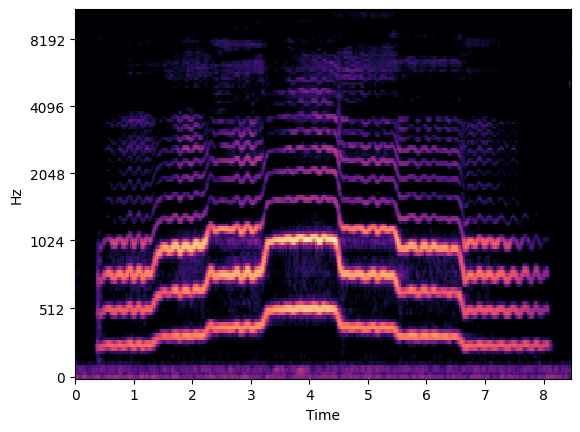

In [46]:
spectr(waveform=waveform1, sr=sr)


## Changed audio file

In [131]:
noise_up(waveform, sr)


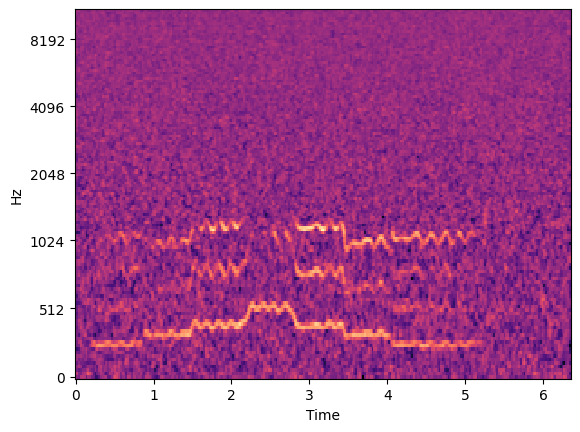

In [132]:
spectr(waveform=waveform, sr=sr)


## Predictions 

In [133]:

raw_predictions = []
model = load_model()
for spectrogram in spectrograms:
    spectrogram_expanded = np.expand_dims(spectrogram, axis=0)
    prediction = predict(X_pred_processed=spectrogram_expanded, model=model) #predict is from main
    raw_predictions.append(prediction)

# print("raw_predictions_sum", np.mean(raw_predictions, axis=0))
prediction_map = {
    0: "Arpeggio",
    1: "Other",
    2: "Scale",
}

mean_prediction = np.mean(raw_predictions, axis=0)
prediction = np.argmax(mean_prediction)
confidence = np.max(mean_prediction) * 100
prediction_str = prediction_map[prediction]

prediction_str, confidence



Load latest model from local registry...

Load latest model from disk...
✅ Model loaded from local disk
1/1 [==============================] - 0s 43ms/step


('Arpeggio', 99.11062121391296)